# Model training

## Import libraries

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [35]:
# Load dataset
heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')

# Split and reduce dataset (reduction only for test purposes)
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.95, random_state = 42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42, stratify=y_train)

## Helper Methods

Method that returns different scores for the passed parameters

In [36]:
def get_scores(y_test, y_predicted):
    return {'accuracy': accuracy_score(y_test, y_predicted),
            'recall': recall_score(y_test, y_predicted),
            'precision': precision_score(y_test, y_predicted),
            'f1_score': f1_score(y_test, y_predicted),
            'f2_score': fbeta_score(y_test, y_predicted, beta=2)}

Method that plots the ROC for the passed parameters

In [37]:
def plot_roc(title, y_test, y_predicted):
    figure = plt.figure()
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic (ROC) - '+title)

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)

    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return figure

Method that plots the feature importance for the passed parameters

In [38]:
def plot_feature_importance(title, estimator):
    figure = plt.figure()
    plt.subplots(1, figsize=(10,10))
    plt.title('Feature Importance for '+title)
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh')
    return figure

Method that plots the learning curve for the passed parameters

In [39]:
def plot_learning_curve():
    # TODO implement
    return ""

## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

{'accuracy': 0.8320825515947468,
 'recall': 0.051094890510948905,
 'precision': 0.048109965635738834,
 'f1_score': 0.049557522123893805,
 'f2_score': 0.050468637346791634}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

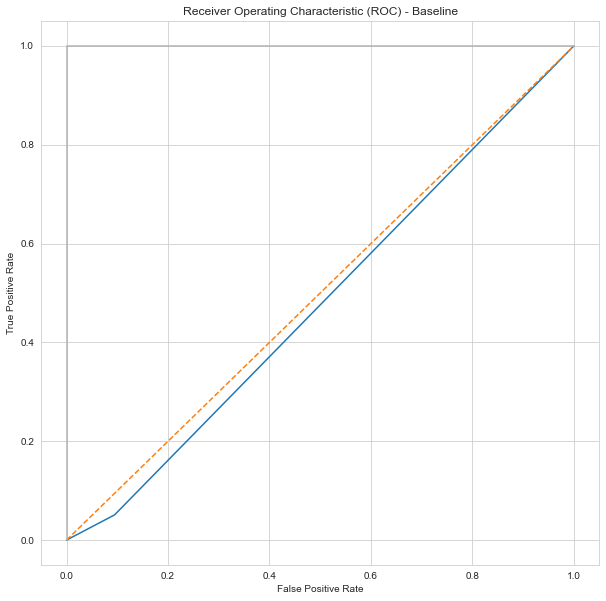

In [40]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

display(get_scores(y_test, y_predicted))
display(plot_roc("Baseline", y_test, y_predicted))

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model selection

knn_estimator


{'n_neighbors': 3}

{'accuracy': 0.9040025015634772,
 'recall': 0.14233576642335766,
 'precision': 0.35135135135135137,
 'f1_score': 0.20259740259740258,
 'f2_score': 0.16155758077879037}

<Figure size 432x288 with 0 Axes>

forest_estimator


{'class_weight': {0: 1, 1: 1}, 'n_estimators': 3}

{'accuracy': 0.8908692933083177,
 'recall': 0.20072992700729927,
 'precision': 0.2972972972972973,
 'f1_score': 0.23965141612200438,
 'f2_score': 0.2146760343481655}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

nn_estimator


{'activation': 'identity'}

{'accuracy': 0.9171357098186367,
 'recall': 0.24817518248175183,
 'precision': 0.5354330708661418,
 'f1_score': 0.33915211970074816,
 'f2_score': 0.27800490596892885}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

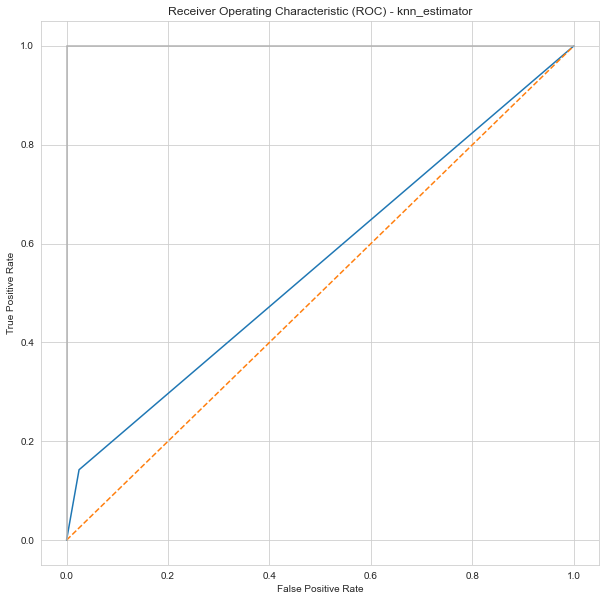

<Figure size 432x288 with 0 Axes>

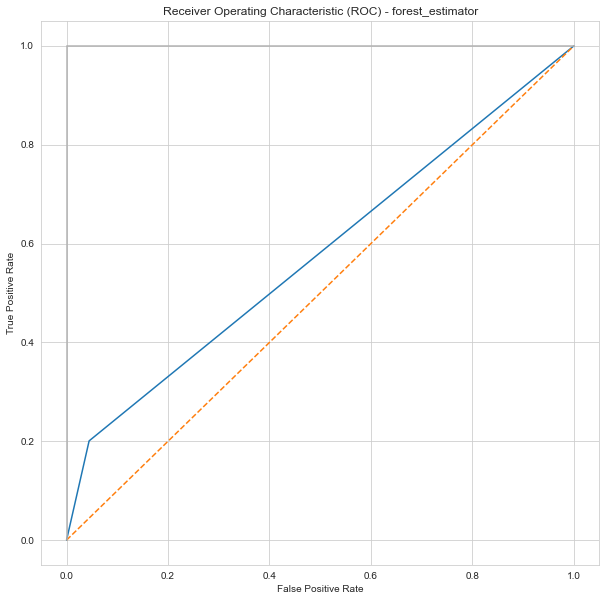

<Figure size 432x288 with 0 Axes>

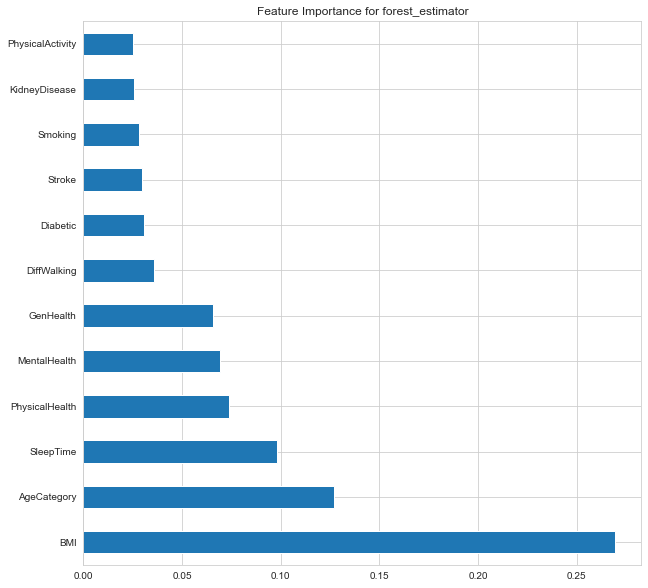

<Figure size 432x288 with 0 Axes>

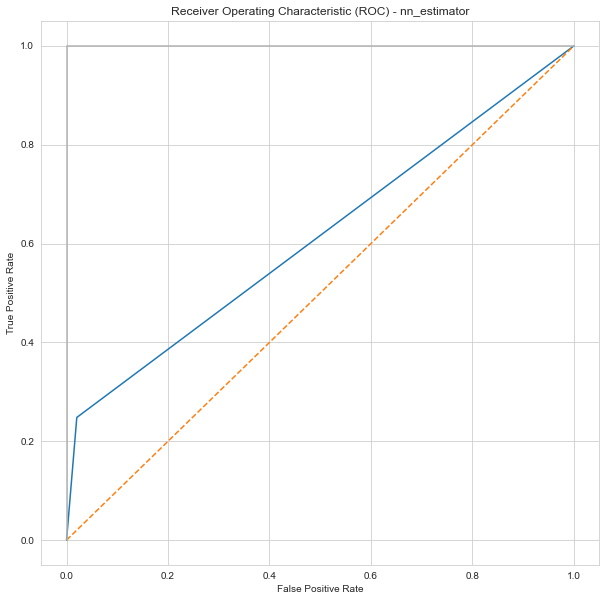

In [41]:
# Enumeration class containing all estimators we want to consider for classification
class Estimator(Enum):
    knn_estimator=KNeighborsClassifier()
    forest_estimator=RandomForestClassifier()
    nn_estimator=MLPClassifier(random_state=1, max_iter=300)
    # svc_estimator=SVC(random_state=0)

# TODO JG: Adjust nn parameters
# Dictionary of parameter grids of the estimators
param_grids = {
    Estimator.knn_estimator: {
        'n_neighbors': [2, 3, 5]
    },
    Estimator.forest_estimator: {
        'class_weight': [{0:1, 1:2}, {0:1, 1:1}],
        'n_estimators': [2, 3, 4, 5]
    },
    #Estimator.svc_estimator: {
    #    'kernel': ['linear', 'poly']
    #},
    Estimator.nn_estimator: {
        'activation': ['identity', 'logistic', 'tanh', 'relu']
    }
}

# TODO BL beautify plotting
for estimator in Estimator:
    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator.value,
                                         param_grid=param_grids.get(estimator),
                                         scoring= make_scorer(fbeta_score, beta=2),
                                         cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
                                         return_train_score=False,
                                         verbose=0
                                         )
    # training and prediction
    grid_search_estimator.fit(X_train, y_train)
    y_predicted = grid_search_estimator.predict(X_test)

    # evaluation of the model
    print(estimator.name)
    display(grid_search_estimator.best_params_)
    display(get_scores(y_test, y_predicted))
    display(plot_roc(estimator.name, y_test, y_predicted))

    if estimator==Estimator.forest_estimator:
        display(plot_feature_importance(estimator.name, grid_search_estimator.best_estimator_))

    #if estimator==Estimator.nn_estimator:
    #    display(plot_learning_curve())

**Conclusion**

TODO: Add conclusion